In [1]:
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import torch

#Download dos dados de preço das ações Itau Unibanco com ticker "ITUB4"
df_reduced = yf.download('ITUB4.SA', start="2016-01-01", end="2024-03-31")
#Gerando um novo dataset reduzido, apenas com Data(index), alta e baixa
#df_reduced = df_ITUB4[['High', 'Low']]

[*********************100%%**********************]  1 of 1 completed


In [2]:
#Ordenando valores por data
df_reduced = df_reduced.sort_values(by='Date')
#Calculando a média entre alta e baixa e atribuindo a coluna median
df_reduced['Median'] = df_reduced[['Open','Adj Close']].mean(axis=1)


<function matplotlib.pyplot.show(close=None, block=None)>

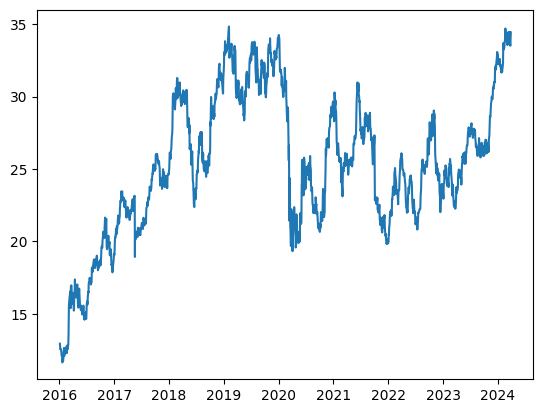

In [3]:
#Gerando gráfico da média de preços da ação
plt.plot(df_reduced['Median'])
plt.show

In [4]:
#Vamos padronizar as médias de valor do ticker
norm = MinMaxScaler(feature_range=(0,1))
normalized = df_reduced.iloc[:, 6:7]
df_reduced['Stand']= norm.fit_transform(normalized.values)

In [5]:
#Retirar eventuais valores nulos
df_reduced = df_reduced.dropna()

#Selecionando a base de treinamento em 80% das observações
x_training = df_reduced['Stand'].iloc[0:math.ceil(len(df_reduced) * 0.8)].values
y_test = df_reduced['Stand'].iloc[math.ceil(len(df_reduced) * 0.8):len(df_reduced)].values


In [6]:
#Checagem dos resources da máquina a qual irá rodar o modelo LSTM
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
#Implementação de validação cruzada para definir os melhores parâmetros para o modelo
from sklearn.model_selection import KFold

# Parâmetros do modelo LSTM
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1
learning_rate = 0.001    
training_steps_backpropagation = 60
test_steps_backpropagation = 30

# Definição do Modelo LSTM
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])  
        return out

# Função para treinamento e validação cruzada
def train_and_cross_validate(model, x_training, y_test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True)  # Divisão em K folds com embaralhamento

    fold_scores = []
     # Inicialização do modelo
    model = LSTMModel(input_size, hidden_size, num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_func = torch.nn.MSELoss(reduction='mean')
    print(model)
    print(optimizer)
    print(loss_func)
    
    #Transformando os dados em arrays de duas dimensões
    x_training = np.reshape(x_training, (-1,1))
    y_test = np.reshape(y_test, (-1,1))
    x_training.shape
    y_test.shape
        
    for train_index, val_index in kf.split (x_training):
        # Divisão dos dados em treinamento e validação
        x_train, x_val = torch.tensor(x_training[train_index]).float(), torch.tensor(x_training[val_index]).float()
        
        for test_index, val_index in kf.split (y_test):
            y_train, y_val = torch.tensor(y_test[test_index]).float(), torch.tensor(y_test[val_index]).float()

        # Inicialização do modelo
        model_instance = model

        # Treinamento do modelo
        for epoch in range(num_epochs):
            model_instance.train()
            optimizer.zero_grad()
            outputs = model_instance(x_train)
            loss = loss_func(outputs, y_train)
            loss.backward()
            optimizer.step()

        # Avaliação do modelo no fold de validação
        model_instance.eval()
        with torch.no_grad():
            val_outputs = model_instance(x_val)
            val_loss = loss_func(val_outputs, y_val).item()
            fold_scores.append(val_loss)

    return np.mean(fold_scores)
    
    

# Configuração dos parâmetros
num_epochs = 10

# Execução da validação cruzada e obtenção do desempenho médio
mean_cross_val_score = train_and_cross_validate(LSTMModel, x_training, y_test)

print(f'Desempenho médio na validação cruzada: {mean_cross_val_score}')

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
MSELoss()


RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cpu and parameter tensor at cuda:0

In [ ]:
#Fase de treino e tunning dos parametros
epochs = 100
training_hist = []
test_hist = []

#Loop de treinamento do modelo
for epoch in range(epochs):
    perda_total_treino = 0.0
    
    #Treinamento do modelo
    model.train()
    for batch_x_training, batch_y_training in training_loader:
        batch_x_training, batch_y_training = batch_x_training.to(device), batch_y_training.to(device)
        
        predictions_training = model(batch_x_training)
        
        loss_training = loss_func(predictions_training, batch_y_training)
        
        optimizer.zero_grad()
        loss_training.backward()
        optimizer.step
        
        perda_total_treino += loss_training.item()
        
    #Calculo da média da perda na base de treino e a acurácia do modelo
    loss_medio_treino = perda_total_treino / len(training_loader)
    training_hist.append(loss_medio_treino)
    
    #Validação do modelo na base de teste
    model.eval()    
    with torch.no_grad():
        perda_total_teste = 0.0
        
        #Avaliação do modelo
        for batch_x_test, batch_y_test in test_loader:
            batch_x_test, batch_y_test = batch_x_test.to(device), batch_y_test.to(device)
            
            predictions_test = model(batch_x_test)
            
            loss_test = loss_func(predictions_test, batch_y_test)
            
            perda_total_teste += loss_test.item()

        #Calculo da média da perda na base de teste e a acurácia do modelo
        loss_medio_teste = perda_total_teste / len(test_loader)
        test_hist.append(loss_medio_teste)
    
    #Apresentando as perdas médias na base de treino e na base de teste
    if(epoch + 1)%10 == 0:
        print(f'Epoca[{epoch+1}/{epochs}] - Perda de treino médio: {loss_medio_treino:.4f}, Perda de teste médio: {loss_medio_teste:.4f}')

In [ ]:
#Verificando as perdas na base de treino e de teste
x = np.linspace(1, epochs, epochs)
plt.plot(x, training_hist, scalex=False, label="Loss de treino")
plt.plot(x, test_hist, label='Loss de teste')
plt.legend()
plt.show()

In [ ]:
#Momento de predição dos valores
passos_predicao = 50

#Conversão para NumPy
sequencia_plotagem = x_test.squeeze().cpu().numpy()

#Usando os ultimos 50 dias de dados como ponto de inicio
hist_data = sequencia_plotagem[-1]

#Lista para armazenagem dos valores
valores_preditos = []

#Predição dos valores
with torch.no_grad():
    for _ in range(passos_predicao*2):
        #Preparação do tensor par ao modelo
        hist_data_tensor = torch.as_tensor(hist_data).view(1,-1,1).float().to(device)
        
        #Modelo em funcionamento para predizer o próximo valor
        valor_predito = model(hist_data_tensor).cpu().numpy()[0,0]
        
        #Adicionando os valores preditos na lista criada anteriormente
        valores_preditos.append(valor_predito[0])
        
        #Atualizando os valores históticos para retirar o mais antigo e adicionar os valores preditos
        hist_data = np.roll(hist_data, shift=-1)
        hist_data[-1] = valor_predito

#Gerando data futura

ultima_data = df_reduced.iloc[math.ceil(len(df_reduced) * 0.8):len(df_reduced)].index[-1]

#Gerando próximos 15 dias
datas_futuras = pd.date_range(start=ultima_data + pd.DateOffset(1), periods=15)

#Combinando o index de datas original às datas futuras
index_combinado = df_reduced.iloc[math.ceil(len(df_reduced) * 0.8):len(df_reduced)].index.append(datas_futuras)

In [ ]:
#Agora para melhor visualização é necessário plotar os valores
plt.rcParams['figure.figsize'] = [10,5]

#Plotagem dos dados de teste
plt.plot(df_reduced.iloc[math.ceil(len(df_reduced) * 0.8):len(df_reduced)].index[-100:-50], df_reduced.iloc[math.ceil(len(df_reduced) * 0.8):len(df_reduced)].Median[-100:-50], label = "Dados_teste", color = "b" )

#Reversão da escala dos dados
casos_originais = norm.inverse_transform(np.expand_dims(sequencia_plotagem[-1], axis=0)).flatten()

#Dados históricos usados como input na predição
plt.plot(df_reduced.iloc[math.ceil(len(df_reduced) * 0.8):len(df_reduced)].index[-50:], casos_originais, label='Valores_atuais', color='green')

#Valores preditos pelo modelo
#Reversão da escala de transformação
casos_preditos = norm.inverse_transform(np.expand_dims(valores_preditos, axis=0)).flatten()

#Plotando valores preditos
plt.plot(index_combinado[-100:], casos_preditos, label='Valores_preditos', color='red')

#
plt.xlabel('Tempo')
plt.ylabel('Valor')
plt.legend()
plt.title('Predição valores de ITUB4')
plt.grid(True)

In [ ]:
#Estatísticas da predição
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(casos_originais,casos_preditos[:50], squared=False)
print(rmse)

valor_medio_original = np.mean(casos_originais)
valor_medio_predicao = np.mean(casos_preditos)
print(valor_medio_original)
print(valor_medio_predicao)

desvpad_originais = np.std(casos_originais)
desvpad_preditos = np.std(casos_preditos)
print(desvpad_originais)
print(desvpad_preditos)

Errpad_originais = desvpad_originais/len(casos_originais)
Errpad_preditos = desvpad_preditos/len(casos_preditos)
print(Errpad_originais)
print(Errpad_preditos)
